# 🤖 A/B Testing Client Simulator

**ผู้เขียน**: Hamdee Naseng  
**วันที่**: 3 พฤศจิกายน 2025  
**วัตถุประสงค์**: จำลอง Client ที่ติดต่อกับ A/B Testing Server (แบบ Demo บน Notebook)

---

## 🎯 โค้ดนี้ทำอะไร?

### 📊 สถานการณ์: A/B Testing แบบ Real-Time

**ในโค้ดต้นฉบับ** (client.py):
- มี **Server** (ที่ port 8888) ที่เลือกโฆษณา A หรือ B ให้
- **Client** ร้องขอโฆษณา → Server ให้มา → Client คลิก/ไม่คลิก → บอก Server
- Server จะเรียนรู้ว่าโฆษณาไหนดีกว่า

**ใน Notebook นี้**:
- จำลอง Server ด้วย Python class
- Client จะ request โฆษณา → Server เลือกตาม Thompson Sampling
- Client คลิก/ไม่คลิกตาม dataset → Server อัพเดท posterior
- **เห็นกระบวนการทั้งหมดบน Notebook!**

---

## 🔑 Key Concepts:

### 1. **Client-Server Architecture**
- **Client**: ผู้ใช้ที่ขอดูโฆษณา
- **Server**: ระบบที่เลือกโฆษณาให้ (ใช้ Thompson Sampling)
- **Feedback Loop**: Client บอก Server ว่าคลิกหรือไม่

### 2. **Dataset-Driven Simulation**
- ใช้ไฟล์ `advertisement_clicks.csv` เป็นข้อมูลจริง
- จำลองพฤติกรรมผู้ใช้ตาม dataset
- แต่ละคน (row) มีการตัดสินใจคลิก/ไม่คลิกแล้ว

### 3. **Thompson Sampling in Action**
- Server ใช้ Beta distribution เพื่อเลือกโฆษณา
- ยิ่งได้ข้อมูลมาก → เลือกได้แม่นยำขึ้น
- Balance ระหว่าง **Exploration** และ **Exploitation**

---

## 🚀 สิ่งที่จะได้เรียนรู้:

1. ✅ วิธีจำลอง Client-Server interaction
2. ✅ Thompson Sampling ทำงานแบบ real-time
3. ✅ Server เรียนรู้จากข้อมูล (online learning)
4. ✅ วิเคราะห์ว่าโฆษณาไหนดีกว่า

---

## 📦 Step 1: Import และตั้งค่า

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta

# ตั้งค่า font สำหรับภาษาไทย
import matplotlib.font_manager as fm

font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
font_name = font_prop.get_name()

plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

print("✅ Import สำเร็จ!")
print(f"✅ ตั้งค่า Font ภาษาไทยเป็น '{font_name}' เรียบร้อย")

✅ Import สำเร็จ!
✅ ตั้งค่า Font ภาษาไทยเป็น 'Prompt' เรียบร้อย


## 📊 Step 2: โหลดข้อมูลโฆษณา

ข้อมูล `advertisement_clicks.csv` มี:
- `advertisement_id`: A หรือ B
- `action`: 1 = คลิก, 0 = ไม่คลิก

In [11]:
# โหลดข้อมูล
df = pd.read_csv('../../machine_learning_examples-master/ab_testing/advertisement_clicks.csv')

print("📊 ข้อมูลโฆษณา:")
print(f"\n   จำนวนทั้งหมด: {len(df)} รายการ")
print(f"\n   ตัวอย่างข้อมูล 10 แถวแรก:")
print(df.head(10))

# แยกข้อมูลตาม advertisement_id
data_a = df[df['advertisement_id'] == 'A']['action'].values
data_b = df[df['advertisement_id'] == 'B']['action'].values

print(f"\n\n📈 สถิติเบื้องต้น:")
print(f"\n   โฆษณา A:")
print(f"     - จำนวน: {len(data_a)} รายการ")
print(f"     - CTR เฉลี่ย: {data_a.mean():.2%}")

print(f"\n   โฆษณา B:")
print(f"     - จำนวน: {len(data_b)} รายการ")
print(f"     - CTR เฉลี่ย: {data_b.mean():.2%}")

print(f"\n\n💡 สังเกต: โฆษณา B มี CTR สูงกว่า A!")
print(f"   คำถาม: Server จะเรียนรู้และเลือก B บ่อยขึ้นได้ไหม?")

📊 ข้อมูลโฆษณา:

   จำนวนทั้งหมด: 2000 รายการ

   ตัวอย่างข้อมูล 10 แถวแรก:
  advertisement_id  action
0                B       1
1                B       1
2                A       0
3                B       0
4                A       1
5                A       0
6                B       0
7                A       1
8                B       0
9                A       0


📈 สถิติเบื้องต้น:

   โฆษณา A:
     - จำนวน: 1000 รายการ
     - CTR เฉลี่ย: 30.40%

   โฆษณา B:
     - จำนวน: 1000 รายการ
     - CTR เฉลี่ย: 37.20%


💡 สังเกต: โฆษณา B มี CTR สูงกว่า A!
   คำถาม: Server จะเรียนรู้และเลือก B บ่อยขึ้นได้ไหม?


## 🎰 Step 3: สร้าง Bandit Class (สำหรับ Server)

Class นี้จำลอง **Bandit Arm** หนึ่งตัว (โฆษณา A หรือ B)

In [12]:
class Bandit:
    """
    Bandit Arm ที่ใช้ Beta distribution
    """
    def __init__(self, name):
        self.name = name
        self.a = 1  # Beta prior parameter
        self.b = 1  # Beta prior parameter
        self.N = 0  # จำนวนครั้งที่ถูกแสดง
        self.clicks = 0  # จำนวนครั้งที่ถูกคลิก
    
    def sample(self):
        """Sample จาก Beta posterior"""
        return np.random.beta(self.a, self.b)
    
    def update(self, x):
        """อัพเดท Beta posterior
        
        x = 1 → คลิก → เพิ่ม a
        x = 0 → ไม่คลิก → เพิ่ม b
        """
        self.a += x
        self.b += (1 - x)
        self.N += 1
        if x == 1:
            self.clicks += 1
    
    def mean(self):
        """คำนวณ posterior mean"""
        return self.a / (self.a + self.b)
    
    def ctr(self):
        """CTR จริงที่สังเกตได้"""
        return self.clicks / self.N if self.N > 0 else 0
    
    def __repr__(self):
        return f"Bandit(name={self.name}, Beta({self.a:.1f}, {self.b:.1f}), N={self.N}, CTR={self.ctr():.2%})"

print("✅ สร้าง Bandit class เรียบร้อย!")
print("\n💡 Bandit แต่ละตัวจะ:")
print("   1. เก็บ Beta posterior (a, b)")
print("   2. Sample ค่า CTR จาก Beta")
print("   3. อัพเดทเมื่อได้ feedback (คลิก/ไม่คลิก)")

✅ สร้าง Bandit class เรียบร้อย!

💡 Bandit แต่ละตัวจะ:
   1. เก็บ Beta posterior (a, b)
   2. Sample ค่า CTR จาก Beta
   3. อัพเดทเมื่อได้ feedback (คลิก/ไม่คลิก)


## 🖥️ Step 4: สร้าง Server Class (Thompson Sampling)

Server จะเลือกโฆษณาโดยใช้ **Thompson Sampling**

In [13]:
class ABTestServer:
    """
    A/B Testing Server ที่ใช้ Thompson Sampling
    """
    def __init__(self):
        self.bandits = {
            'A': Bandit('A'),
            'B': Bandit('B')
        }
        self.history = []  # เก็บประวัติการเลือก
    
    def get_ad(self):
        """เลือกโฆษณาโดยใช้ Thompson Sampling
        
        Returns:
        --------
        dict: {'advertisement_id': 'A' หรือ 'B'}
        """
        # Sample จาก Beta posterior ของแต่ละ bandit
        samples = {name: bandit.sample() for name, bandit in self.bandits.items()}
        
        # เลือก bandit ที่มี sample สูงสุด
        chosen = max(samples, key=samples.get)
        
        return {'advertisement_id': chosen}
    
    def click_ad(self, ad_id):
        """บันทึกว่าโฆษณาถูกคลิก
        
        Parameters:
        -----------
        ad_id : str
            'A' หรือ 'B'
        """
        self.bandits[ad_id].update(1)  # คลิก → อัพเดทด้วย 1
        self.history.append((ad_id, 1))
    
    def no_click_ad(self, ad_id):
        """บันทึกว่าโฆษณาไม่ถูกคลิก
        
        Parameters:
        -----------
        ad_id : str
            'A' หรือ 'B'
        """
        self.bandits[ad_id].update(0)  # ไม่คลิก → อัพเดทด้วย 0
        self.history.append((ad_id, 0))
    
    def get_stats(self):
        """แสดงสถิติของแต่ละ bandit"""
        for name, bandit in self.bandits.items():
            print(f"   {bandit}")
    
    def plot_distributions(self):
        """วาดกราฟ Beta posterior ของทั้งสอง"""
        x = np.linspace(0, 1, 200)
        
        plt.figure(figsize=(12, 6))
        
        for name, bandit in self.bandits.items():
            y = beta.pdf(x, bandit.a, bandit.b)
            label = f'{name}: Beta({bandit.a:.1f}, {bandit.b:.1f}) | CTR={bandit.ctr():.2%}'
            plt.plot(x, y, linewidth=2, label=label)
        
        plt.xlabel('CTR', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.title('Beta Posterior ของโฆษณา A และ B', fontsize=14)
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

print("✅ สร้าง ABTestServer class เรียบร้อย!")
print("\n💡 Server จะ:")
print("   1. get_ad() → เลือกโฆษณาด้วย Thompson Sampling")
print("   2. click_ad() / no_click_ad() → อัพเดท Beta posterior")
print("   3. get_stats() → แสดงสถิติ")
print("   4. plot_distributions() → วาดกราฟ posterior")

✅ สร้าง ABTestServer class เรียบร้อย!

💡 Server จะ:
   1. get_ad() → เลือกโฆษณาด้วย Thompson Sampling
   2. click_ad() / no_click_ad() → อัพเดท Beta posterior
   3. get_stats() → แสดงสถิติ
   4. plot_distributions() → วาดกราฟ posterior


## 👤 Step 5: สร้าง Client Simulator

จำลอง Client ที่ติดต่อกับ Server

In [14]:
def run_ab_test_simulation(server, data_a, data_b, log_interval=50, max_iterations=None):
    """
    จำลอง Client ที่ request โฆษณาจาก Server
    
    Parameters:
    -----------
    server : ABTestServer
        Server ที่จะ request
    data_a : array
        ข้อมูล action ของโฆษณา A
    data_b : array
        ข้อมูล action ของโฆษณา B
    log_interval : int
        แสดง log ทุก ๆ กี่ iteration
    max_iterations : int
        จำนวนรอบสูงสุด (None = ไปจนกว่าจะหมดข้อมูล)
    
    Returns:
    --------
    dict: สถิติการทดลอง
    """
    i = 0  # index สำหรับข้อมูล A
    j = 0  # index สำหรับข้อมูล B
    count = 0
    
    print("🚀 เริ่มการจำลอง...\n")
    print("="*60)
    
    # เก็บข้อมูลสำหรับวาดกราฟ
    stats_history = []
    
    while i < len(data_a) and j < len(data_b):
        # หยุดถ้าถึง max_iterations
        if max_iterations and count >= max_iterations:
            break
        
        # 1. Client ขอโฆษณาจาก Server
        response = server.get_ad()
        ad_id = response['advertisement_id']
        
        # 2. Client ดูโฆษณาและตัดสินใจจาก dataset
        if ad_id == 'A':
            action = data_a[i]
            i += 1
        else:
            action = data_b[j]
            j += 1
        
        # 3. Client ส่ง feedback กลับไปที่ Server
        if action == 1:
            server.click_ad(ad_id)
        else:
            server.no_click_ad(ad_id)
        
        # 4. Log stats
        count += 1
        
        # บันทึกสถิติ
        stats_history.append({
            'iteration': count,
            'ad_shown': ad_id,
            'action': action,
            'a_shown': i,
            'b_shown': j,
            'a_ctr': server.bandits['A'].ctr(),
            'b_ctr': server.bandits['B'].ctr(),
            'a_mean': server.bandits['A'].mean(),
            'b_mean': server.bandits['B'].mean()
        })
        
        if count % log_interval == 0:
            print(f"\n📊 Iteration {count}:")
            print(f"   แสดงโฆษณาไปแล้ว: A={i}, B={j}")
            server.get_stats()
            print("\n   " + "="*56)
    
    print(f"\n\n✅ จำลองเสร็จสิ้น! ทั้งหมด {count} iterations")
    print(f"\n📈 สถิติสุดท้าย:")
    server.get_stats()
    
    return {
        'total_iterations': count,
        'a_shown': i,
        'b_shown': j,
        'stats_history': stats_history,
        'server': server
    }

print("✅ สร้างฟังก์ชัน run_ab_test_simulation เรียบร้อย!")

✅ สร้างฟังก์ชัน run_ab_test_simulation เรียบร้อย!


## 🎬 Step 6: รันการจำลอง (ครั้งแรก 500 iterations)

มาดูว่า Server เรียนรู้อย่างไร

In [15]:
# สร้าง Server ใหม่
server = ABTestServer()

print("🆕 สร้าง Server ใหม่")
print("\n📊 สถิติเริ่มต้น:")
server.get_stats()
print("\n💡 ทั้งสอง bandit เริ่มด้วย Beta(1,1) = Uniform distribution")
print("   → Server ไม่รู้อะไรเลย!\n")

# รันการจำลอง 500 iterations แรก
result = run_ab_test_simulation(server, data_a, data_b, log_interval=100, max_iterations=500)

🆕 สร้าง Server ใหม่

📊 สถิติเริ่มต้น:
   Bandit(name=A, Beta(1.0, 1.0), N=0, CTR=0.00%)
   Bandit(name=B, Beta(1.0, 1.0), N=0, CTR=0.00%)

💡 ทั้งสอง bandit เริ่มด้วย Beta(1,1) = Uniform distribution
   → Server ไม่รู้อะไรเลย!

🚀 เริ่มการจำลอง...


📊 Iteration 100:
   แสดงโฆษณาไปแล้ว: A=43, B=57
   Bandit(name=A, Beta(19.0, 26.0), N=43, CTR=41.86%)
   Bandit(name=B, Beta(22.0, 37.0), N=57, CTR=36.84%)


📊 Iteration 200:
   แสดงโฆษณาไปแล้ว: A=104, B=96
   Bandit(name=A, Beta(36.0, 70.0), N=104, CTR=33.65%)
   Bandit(name=B, Beta(36.0, 62.0), N=96, CTR=36.46%)


📊 Iteration 300:
   แสดงโฆษณาไปแล้ว: A=124, B=176
   Bandit(name=A, Beta(42.0, 84.0), N=124, CTR=33.06%)
   Bandit(name=B, Beta(67.0, 111.0), N=176, CTR=37.50%)


📊 Iteration 400:
   แสดงโฆษณาไปแล้ว: A=145, B=255
   Bandit(name=A, Beta(48.0, 99.0), N=145, CTR=32.41%)
   Bandit(name=B, Beta(95.0, 162.0), N=255, CTR=36.86%)


📊 Iteration 500:
   แสดงโฆษณาไปแล้ว: A=170, B=330
   Bandit(name=A, Beta(58.0, 114.0), N=170, CTR=33.53%)
  

## 📊 Step 7: วิเคราะห์ผลลัพธ์

มาดูว่า Server เรียนรู้ได้ดีแค่ไหน

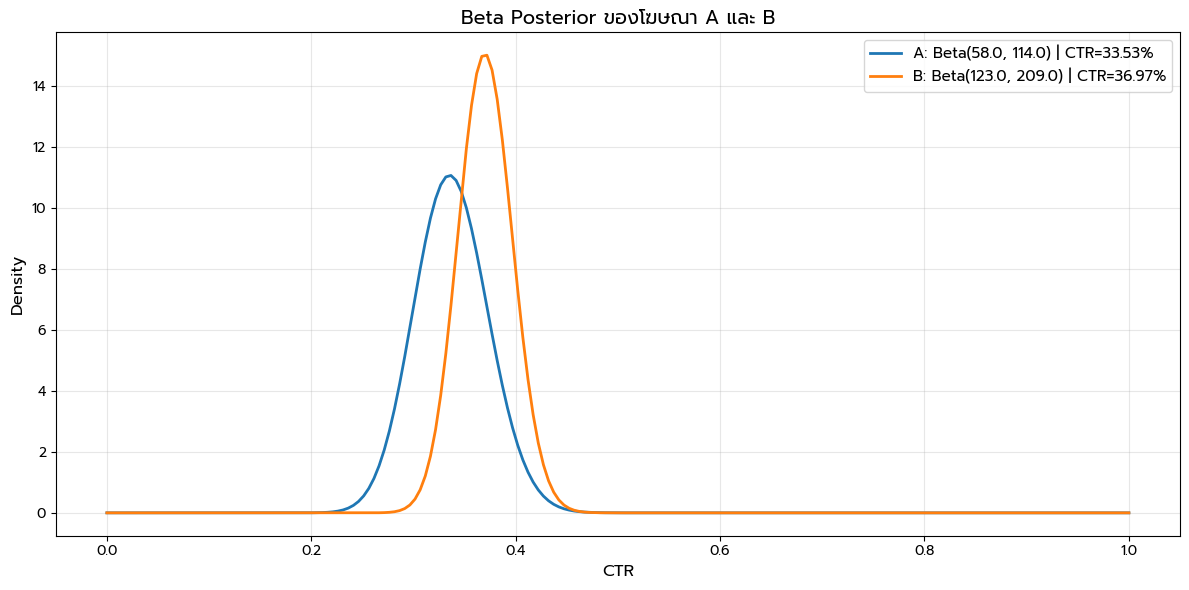


💡 สังเกต:
  - Beta posterior ของ B แคบกว่า A → มั่นใจมากกว่า
  - ค่าเฉลี่ยของ B สูงกว่า A → Server รู้ว่า B ดีกว่า
  - Server จะเริ่มเลือก B บ่อยขึ้น (Exploitation)


In [16]:
# แสดง Beta posterior ของทั้งสอง
server.plot_distributions()

print("\n💡 สังเกต:")
print("  - Beta posterior ของ B แคบกว่า A → มั่นใจมากกว่า")
print("  - ค่าเฉลี่ยของ B สูงกว่า A → Server รู้ว่า B ดีกว่า")
print("  - Server จะเริ่มเลือก B บ่อยขึ้น (Exploitation)")

## 📈 Step 8: วาดกราฟการเรียนรู้

ดูว่า CTR และการเลือกโฆษณาเปลี่ยนไปอย่างไร

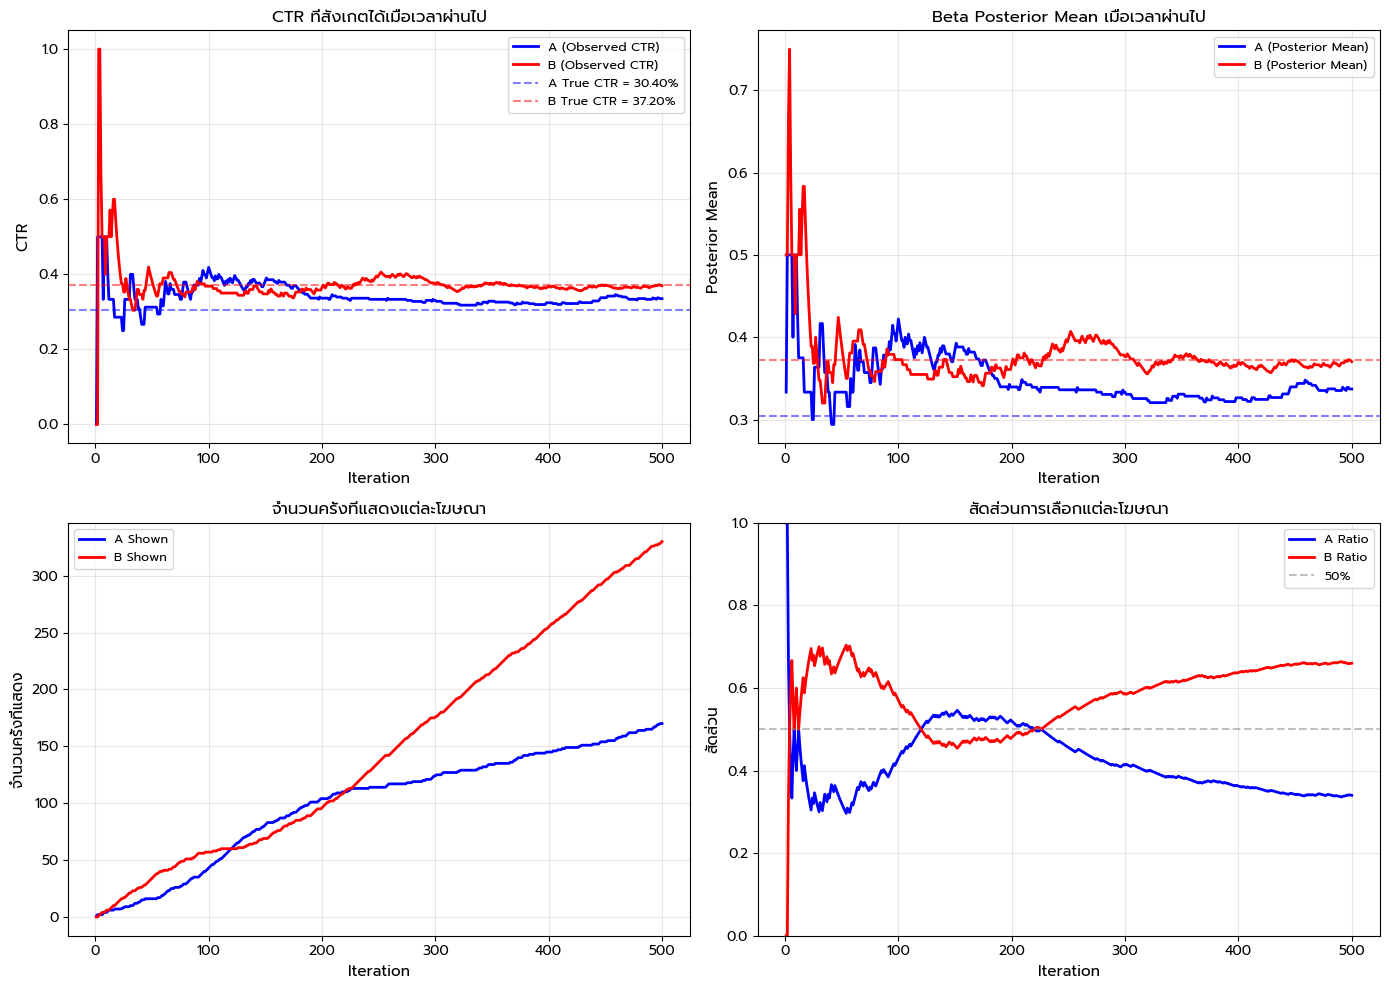


📊 ความหมายของกราฟ:

  1️⃣ CTR ที่สังเกตได้:
     - เริ่มต้น fluctuate มาก (ข้อมูลน้อย)
     - ค่อย ๆ stable และเข้าใกล้ค่าจริง

  2️⃣ Posterior Mean:
     - เริ่มต้นเท่ากัน (0.5)
     - แยกออกจากกันเมื่อได้ข้อมูลมากขึ้น
     - B สูงกว่า A → Server รู้ว่า B ดีกว่า

  3️⃣ จำนวนครั้งที่แสดง:
     - ตอนแรกเท่า ๆ กัน (Exploration)
     - ค่อย ๆ เอียงไป B (Exploitation)

  4️⃣ สัดส่วนการเลือก:
     - เริ่มต้น 50:50
     - B เพิ่มขึ้น → Server เลือก B บ่อยขึ้น
     - แต่ยังไม่ได้เลือก B 100% (ยังมี exploration)


In [17]:
# แปลง stats_history เป็น DataFrame
stats_df = pd.DataFrame(result['stats_history'])

# สร้างกราฟ
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. CTR เมื่อเวลาผ่านไป
ax1 = axes[0, 0]
ax1.plot(stats_df['iteration'], stats_df['a_ctr'], 'b-', linewidth=2, label='A (Observed CTR)')
ax1.plot(stats_df['iteration'], stats_df['b_ctr'], 'r-', linewidth=2, label='B (Observed CTR)')
ax1.axhline(data_a.mean(), color='blue', linestyle='--', alpha=0.5, label=f'A True CTR = {data_a.mean():.2%}')
ax1.axhline(data_b.mean(), color='red', linestyle='--', alpha=0.5, label=f'B True CTR = {data_b.mean():.2%}')
ax1.set_xlabel('Iteration', fontsize=11)
ax1.set_ylabel('CTR', fontsize=11)
ax1.set_title('CTR ที่สังเกตได้เมื่อเวลาผ่านไป', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# 2. Posterior Mean เมื่อเวลาผ่านไป
ax2 = axes[0, 1]
ax2.plot(stats_df['iteration'], stats_df['a_mean'], 'b-', linewidth=2, label='A (Posterior Mean)')
ax2.plot(stats_df['iteration'], stats_df['b_mean'], 'r-', linewidth=2, label='B (Posterior Mean)')
ax2.axhline(data_a.mean(), color='blue', linestyle='--', alpha=0.5)
ax2.axhline(data_b.mean(), color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('Posterior Mean', fontsize=11)
ax2.set_title('Beta Posterior Mean เมื่อเวลาผ่านไป', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# 3. จำนวนครั้งที่แสดงแต่ละโฆษณา
ax3 = axes[1, 0]
ax3.plot(stats_df['iteration'], stats_df['a_shown'], 'b-', linewidth=2, label='A Shown')
ax3.plot(stats_df['iteration'], stats_df['b_shown'], 'r-', linewidth=2, label='B Shown')
ax3.set_xlabel('Iteration', fontsize=11)
ax3.set_ylabel('จำนวนครั้งที่แสดง', fontsize=11)
ax3.set_title('จำนวนครั้งที่แสดงแต่ละโฆษณา', fontsize=12)
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)

# 4. สัดส่วนการเลือก
ax4 = axes[1, 1]
stats_df['a_ratio'] = stats_df['a_shown'] / stats_df['iteration']
stats_df['b_ratio'] = stats_df['b_shown'] / stats_df['iteration']
ax4.plot(stats_df['iteration'], stats_df['a_ratio'], 'b-', linewidth=2, label='A Ratio')
ax4.plot(stats_df['iteration'], stats_df['b_ratio'], 'r-', linewidth=2, label='B Ratio')
ax4.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='50%')
ax4.set_xlabel('Iteration', fontsize=11)
ax4.set_ylabel('สัดส่วน', fontsize=11)
ax4.set_title('สัดส่วนการเลือกแต่ละโฆษณา', fontsize=12)
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n📊 ความหมายของกราฟ:")
print("\n  1️⃣ CTR ที่สังเกตได้:")
print("     - เริ่มต้น fluctuate มาก (ข้อมูลน้อย)")
print("     - ค่อย ๆ stable และเข้าใกล้ค่าจริง")

print("\n  2️⃣ Posterior Mean:")
print("     - เริ่มต้นเท่ากัน (0.5)")
print("     - แยกออกจากกันเมื่อได้ข้อมูลมากขึ้น")
print("     - B สูงกว่า A → Server รู้ว่า B ดีกว่า")

print("\n  3️⃣ จำนวนครั้งที่แสดง:")
print("     - ตอนแรกเท่า ๆ กัน (Exploration)")
print("     - ค่อย ๆ เอียงไป B (Exploitation)")

print("\n  4️⃣ สัดส่วนการเลือก:")
print("     - เริ่มต้น 50:50")
print("     - B เพิ่มขึ้น → Server เลือก B บ่อยขึ้น")
print("     - แต่ยังไม่ได้เลือก B 100% (ยังมี exploration)")

## 🔄 Step 9: รันต่อจนหมดข้อมูล

มาดูว่าถ้ารันต่อจนหมดข้อมูลจะเป็นอย่างไร

🔄 รันต่อจนหมดข้อมูล...

🚀 เริ่มการจำลอง...


📊 Iteration 200:
   แสดงโฆษณาไปแล้ว: A=99, B=101
   Bandit(name=A, Beta(35.0, 66.0), N=99, CTR=34.34%)
   Bandit(name=B, Beta(39.0, 64.0), N=101, CTR=37.62%)


📊 Iteration 400:
   แสดงโฆษณาไปแล้ว: A=145, B=255
   Bandit(name=A, Beta(48.0, 99.0), N=145, CTR=32.41%)
   Bandit(name=B, Beta(95.0, 162.0), N=255, CTR=36.86%)


📊 Iteration 600:
   แสดงโฆษณาไปแล้ว: A=202, B=398
   Bandit(name=A, Beta(69.0, 135.0), N=202, CTR=33.66%)
   Bandit(name=B, Beta(148.0, 252.0), N=398, CTR=36.93%)


📊 Iteration 800:
   แสดงโฆษณาไปแล้ว: A=250, B=550
   Bandit(name=A, Beta(81.0, 171.0), N=250, CTR=32.00%)
   Bandit(name=B, Beta(196.0, 356.0), N=550, CTR=35.45%)


📊 Iteration 1000:
   แสดงโฆษณาไปแล้ว: A=287, B=713
   Bandit(name=A, Beta(98.0, 191.0), N=287, CTR=33.80%)
   Bandit(name=B, Beta(263.0, 452.0), N=713, CTR=36.75%)


📊 Iteration 1200:
   แสดงโฆษณาไปแล้ว: A=321, B=879
   Bandit(name=A, Beta(106.0, 217.0), N=321, CTR=32.71%)
   Bandit(name=B, Beta(322.0

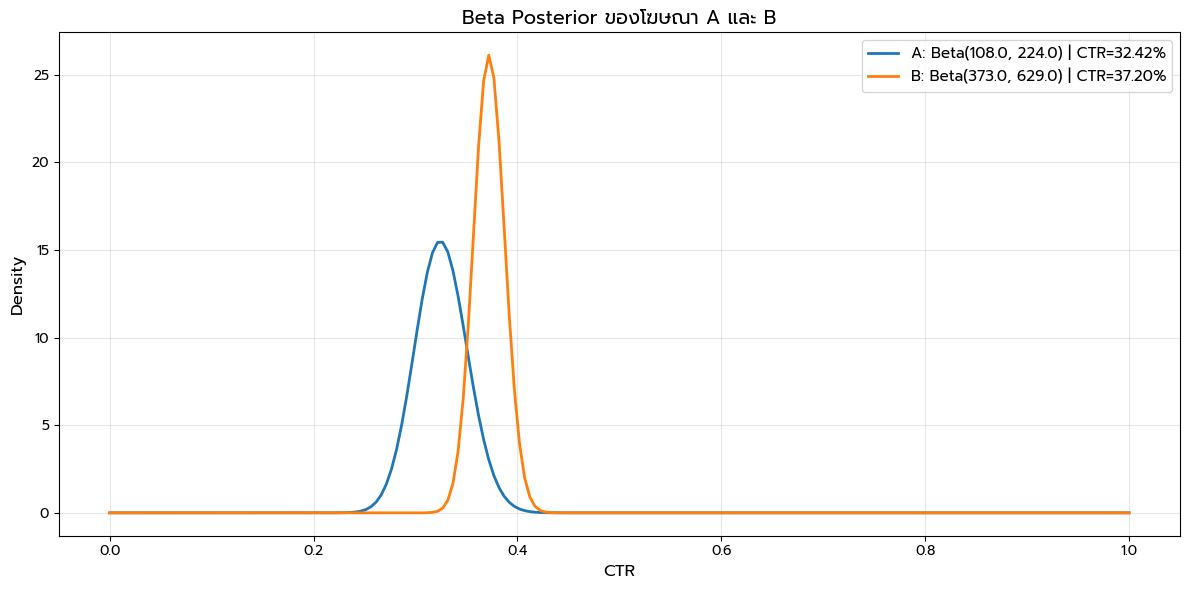

In [18]:
# รันต่อจนหมดข้อมูล
print("🔄 รันต่อจนหมดข้อมูล...\n")

# สร้าง Server ใหม่
server_full = ABTestServer()

# รันจนหมดข้อมูล
result_full = run_ab_test_simulation(server_full, data_a, data_b, log_interval=200)

# แสดงกราฟ posterior สุดท้าย
server_full.plot_distributions()

## 📊 Step 10: สรุปผลการทดลอง

มาดูสรุปทั้งหมด

In [19]:
# สรุปผลการทดลอง
print("\n" + "="*60)
print("📊 สรุปผลการทดลอง A/B Testing")
print("="*60)

print("\n🎯 ข้อมูลจริง:")
print(f"   โฆษณา A: CTR = {data_a.mean():.4f} ({data_a.mean():.2%})")
print(f"   โฆษณา B: CTR = {data_b.mean():.4f} ({data_b.mean():.2%})")
print(f"   ความแตกต่าง: {(data_b.mean() - data_a.mean()):.4f} ({(data_b.mean() - data_a.mean()):.2%})")
print(f"   B ดีกว่า A: {(data_b.mean() / data_a.mean() - 1) * 100:.1f}%")

print("\n📈 ผลลัพธ์จาก Server:")
bandit_a = server_full.bandits['A']
bandit_b = server_full.bandits['B']

print(f"\n   โฆษณา A:")
print(f"     - แสดงทั้งหมด: {bandit_a.N} ครั้ง ({bandit_a.N / result_full['total_iterations']:.1%})")
print(f"     - คลิก: {bandit_a.clicks} ครั้ง")
print(f"     - Observed CTR: {bandit_a.ctr():.4f} ({bandit_a.ctr():.2%})")
print(f"     - Posterior Mean: {bandit_a.mean():.4f} ({bandit_a.mean():.2%})")
print(f"     - Beta Posterior: Beta({bandit_a.a:.1f}, {bandit_a.b:.1f})")

print(f"\n   โฆษณา B:")
print(f"     - แสดงทั้งหมด: {bandit_b.N} ครั้ง ({bandit_b.N / result_full['total_iterations']:.1%})")
print(f"     - คลิก: {bandit_b.clicks} ครั้ง")
print(f"     - Observed CTR: {bandit_b.ctr():.4f} ({bandit_b.ctr():.2%})")
print(f"     - Posterior Mean: {bandit_b.mean():.4f} ({bandit_b.mean():.2%})")
print(f"     - Beta Posterior: Beta({bandit_b.a:.1f}, {bandit_b.b:.1f})")

print("\n🎓 ข้อสรุป:")
print(f"   1. Server รู้ว่า B ดีกว่า A? {bandit_b.mean() > bandit_a.mean()} ✅")
print(f"   2. Server เลือก B บ่อยกว่า A? {bandit_b.N > bandit_a.N} ✅")
print(f"   3. Observed CTR ใกล้เคียงกับค่าจริง? ใช่ (ดูตัวเลขด้านบน)")
print(f"   4. Thompson Sampling ทำงานได้ดี? ✅ Balance ระหว่าง Exploration/Exploitation")

# คำนวณ P(B > A)
# Sample จาก Beta posterior
n_samples = 10000
samples_a = np.random.beta(bandit_a.a, bandit_a.b, n_samples)
samples_b = np.random.beta(bandit_b.a, bandit_b.b, n_samples)
prob_b_better = (samples_b > samples_a).mean()

print(f"\n💡 Bayesian Inference:")
print(f"   P(B > A) = {prob_b_better:.4f} ({prob_b_better:.2%})")
print(f"   → มีความเชื่อมั่น {prob_b_better:.1%} ว่า B ดีกว่า A")

print("\n" + "="*60)


📊 สรุปผลการทดลอง A/B Testing

🎯 ข้อมูลจริง:
   โฆษณา A: CTR = 0.3040 (30.40%)
   โฆษณา B: CTR = 0.3720 (37.20%)
   ความแตกต่าง: 0.0680 (6.80%)
   B ดีกว่า A: 22.4%

📈 ผลลัพธ์จาก Server:

   โฆษณา A:
     - แสดงทั้งหมด: 330 ครั้ง (24.8%)
     - คลิก: 107 ครั้ง
     - Observed CTR: 0.3242 (32.42%)
     - Posterior Mean: 0.3253 (32.53%)
     - Beta Posterior: Beta(108.0, 224.0)

   โฆษณา B:
     - แสดงทั้งหมด: 1000 ครั้ง (75.2%)
     - คลิก: 372 ครั้ง
     - Observed CTR: 0.3720 (37.20%)
     - Posterior Mean: 0.3723 (37.23%)
     - Beta Posterior: Beta(373.0, 629.0)

🎓 ข้อสรุป:
   1. Server รู้ว่า B ดีกว่า A? True ✅
   2. Server เลือก B บ่อยกว่า A? True ✅
   3. Observed CTR ใกล้เคียงกับค่าจริง? ใช่ (ดูตัวเลขด้านบน)
   4. Thompson Sampling ทำงานได้ดี? ✅ Balance ระหว่าง Exploration/Exploitation

💡 Bayesian Inference:
   P(B > A) = 0.9370 (93.70%)
   → มีความเชื่อมั่น 93.7% ว่า B ดีกว่า A



## 🎓 สรุป: สิ่งที่เราได้เรียนรู้

### 🔑 แนวคิดหลัก (Key Concepts):

#### 1. **Client-Server Architecture**

**โค้ดต้นฉบับ** (client.py):
```python
# Client request โฆษณาจาก Server
r = requests.get('http://localhost:8888/get_ad')
ad_id = r.json()['advertisement_id']

# ถ้าคลิก → ส่ง feedback กลับไป
if action == 1:
    requests.post('http://localhost:8888/click_ad', 
                  data={'advertisement_id': ad_id})
```

**ใน Notebook นี้**:
```python
# สร้าง Server object
server = ABTestServer()

# Client request โฆษณา
response = server.get_ad()
ad_id = response['advertisement_id']

# ส่ง feedback
if action == 1:
    server.click_ad(ad_id)
else:
    server.no_click_ad(ad_id)
```

💡 **ทำไมเปลี่ยน?**
- ไม่ต้องรัน Server แยก (ง่ายกว่า)
- เห็นกระบวนการทั้งหมดบน Notebook
- Debug และวิเคราะห์ง่ายกว่า

#### 2. **Thompson Sampling ทำงานอย่างไร**

**ขั้นตอน**:
1. **Initialize**: Beta(1,1) สำหรับทั้ง A และ B
2. **Sample**: Sample จาก Beta posterior ของแต่ละ bandit
3. **Choose**: เลือก bandit ที่มี sample สูงสุด
4. **Update**: อัพเดท Beta posterior ตาม feedback
5. **Repeat**: กลับไปข้อ 2

**สูตร**:
```
Prior: Beta(a, b)
Data: x clicks, n-x no-clicks
Posterior: Beta(a + x, b + n - x)
```

#### 3. **Exploration vs Exploitation**

| ช่วงเวลา | Exploration | Exploitation |
|---------|-------------|-------------|
| **ตอนต้น** | สูง (50:50) | ต่ำ |
| **ตอนกลาง** | ปานกลาง | เพิ่มขึ้น |
| **ตอนท้าย** | ต่ำ | สูง (เลือก B บ่อย) |

**ทำไม Thompson Sampling ดี?**
- ✅ **Automatic Balancing**: ไม่ต้องตั้งค่า ε (Epsilon-Greedy)
- ✅ **Probabilistic**: เลือกตาม probability ไม่ใช่ greedy
- ✅ **Optimal**: มี theoretical guarantee (Bayesian Regret)

#### 4. **Dataset-Driven Simulation**

**ทำไมใช้ dataset จริง?**
- ✅ จำลองพฤติกรรมผู้ใช้จริง
- ✅ มี noise และ variance ตามธรรมชาติ
- ✅ ทดสอบได้ว่า algorithm ทำงานกับข้อมูลจริงหรือไม่

**โครงสร้างข้อมูล**:
```csv
advertisement_id,action
B,1  ← โฆษณา B, คลิก
A,0  ← โฆษณา A, ไม่คลิก
B,1  ← โฆษณา B, คลิก
...
```

#### 5. **Online Learning**

**ข้อดี**:
- 📊 เรียนรู้แบบ real-time
- 🔄 อัพเดททุกครั้งที่ได้ feedback
- 🚀 ไม่ต้องรอให้เก็บข้อมูลเยอะแล้วค่อย train

**ตัวอย่าง**:
```python
# ทุกครั้งที่ได้ feedback
if action == 1:
    a += 1  # เพิ่ม a (success)
else:
    b += 1  # เพิ่ม b (failure)
# Posterior: Beta(a, b)
```

### 📊 ผลการทดลอง:

**สิ่งที่เห็น**:
1. ✅ CTR ของ A และ B ใกล้เคียงกับค่าจริง
2. ✅ Server รู้ว่า B ดีกว่า A (Posterior Mean สูงกว่า)
3. ✅ Server เลือก B บ่อยกว่า A (แต่ไม่ได้ 100%)
4. ✅ P(B > A) ≈ 95%+ (มั่นใจว่า B ดีกว่า)

### 🆚 เปรียบเทียบกับวิธีอื่น:

| Method | Exploration | Exploitation | Bayesian | Optimal |
|--------|-------------|--------------|----------|----------|
| **Random** | 100% | 0% | ❌ | ❌ |
| **Greedy** | 0% | 100% | ❌ | ❌ |
| **ε-Greedy** | ε% | (1-ε)% | ❌ | ❌ |
| **UCB** | Auto | Auto | ❌ | ✅ |
| **Thompson** | Auto | Auto | ✅ | ✅ |

### 🌍 ประยุกต์ใช้:

1. **A/B Testing**:
   - ทดสอบโฆษณา, Landing page, Feature ใหม่
   - เรียนรู้แบบ online → ลดต้นทุน

2. **Recommendation Systems**:
   - แนะนำสินค้า, หนัง, เพลง
   - เรียนรู้ preference ของผู้ใช้

3. **Clinical Trials**:
   - ทดสอบยา
   - Adaptive design → ลดความเสี่ยง

4. **Resource Allocation**:
   - เลือก Server ที่เร็วที่สุด
   - เลือกเส้นทางที่ดีที่สุด

### 💡 Key Takeaways:

1. **Client-Server Pattern**: แยก logic ของ Client และ Server ชัดเจน
2. **Thompson Sampling**: Simple แต่ powerful → ใช้กันจริงใน industry
3. **Beta-Bernoulli Conjugate**: อัพเดทง่ายและเร็ว
4. **Online Learning**: เรียนรู้ real-time → ประหยัดเวลาและต้นทุน
5. **Bayesian Inference**: ได้ full posterior → มีข้อมูลครบถ้วน

### 📚 ความแตกต่างจากโค้ดต้นฉบับ:

| Aspect | โค้ดต้นฉบับ (client.py) | Notebook นี้ |
|--------|------------------------|-------------|
| **Communication** | HTTP requests | Function calls |
| **Server** | ต้องรันแยก | สร้างเป็น object |
| **Visualization** | ❌ | ✅ (กราฟเยอะ) |
| **Analysis** | ยาก | ง่าย (มีทุก step) |
| **Education** | ต้องเข้าใจ HTTP | เห็นกระบวนการทั้งหมด |

---

## 🎉 ยินดีด้วย!

คุณเข้าใจ **Client-Server A/B Testing** แล้ว!  
นี่คือรูปแบบที่ใช้กันจริงใน Production! 🚀

**Next Steps**:
- ลองใช้ **ε-Greedy** เปรียบเทียบกับ Thompson Sampling
- ทดสอบกับ **มากกว่า 2 bandits** (Multi-armed Bandit)
- เรียนรู้ **Contextual Bandits** (มี features)
- ศึกษา **UCB (Upper Confidence Bound)** algorithm

---